# Continuous Control Using Reinforcement Learning

## The Cart-Pole System
One tries to balance a pole on top of a cart. This pole is pinned to the cart and can otherwise rotate freely.  Your objective is to prevent the pole from falling down.  The only actions available are to accelerate the cart to the right or left.  We intend to use policy gradients to train a neural network to choose these actions and balance a pole on a cart the available actions are to accelerate the cart to the left or right.  State variables that the agent can observe are the position and the velocity of the cart, and the angular position of the pole and its angular velocity, making this a four dimensional continuous state space.  

## Deep $Q$-Network
In a Markov Decision Process, the $Q(s,a)$ function represents the value of being in a state and taking an action, accounting for all  discounted rewards for all future traversible states (see <a href="https://en.wikipedia.org/wiki/Bellman_equation#Example">Bellman Equation</a>).  We design a neural network to estimate this value and use it to direct an agent to take favorable actions.  Due to the contractive property of the Bellman Equation, this network can train against itself by setting a target $Q$ value according to the observed reward from an instance of state and action.  In other words, for an instance of transitioning between state $s$ to state $s'$ under the chosen action, $a$, and obtaining reward, $R$, the target $Q$ value is defined:

$$ Q_{\textrm{target}}(s,a) = R + \gamma \max_{a'} Q_{\textrm{model}}(s',a') $$

by the definition of $Q$, if the model is exact then $Q_{\textrm{target}} = Q_{\textrm{model}}$ for all $s$ and $a$.  As such, the error of this estimation is given by $E = Q_{\textrm{target}}(s,a) - Q_{\textrm{model}}(s,a) $,  and we believe fitting the models to this target will converge to the true $Q$ values of the system.


### logbook:
for a DQN of 1,282 weights, and a replay buffer, loss = least squared error, optimizer = Adam.  No extra schemes.  The network/agent could perform the cart pole task consistently after about 1800 training episodes.  Hyper parameters were training batches of 32 experiments, epsilon greedy exploration with eps =0.9 decreasing to eps=0.01 linearly over the first 500 episodes.  learning rate = 0.005, discount factor = 0.95.  

This experiment presented in the above paragraph is very similar (barring some modification to the hyperparameters) to the first example presented in the book by A. Geron, but he gives up after 800 steps, and remarks on the instability of this model (which I also observed), to discuss better training techniques to grant more stability to the models.


In [15]:
import gymnasium as gym
import numpy as np
import random
from collections import deque

import tensorflow as tf
import keras
from keras.layers import Input
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam

from matplotlib import pyplot as plt

In [16]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
def draw_state(env, step=0, info=""):
    plt.clf()
    plt.imshow(env.render())
    plt.title("Cart Pole | Step: %d %s" % (step, info))
    plt.axis('off')
    plt.show()

    #display.clear_output(wait=True)
    #display.display(plt.gcf())

observation :  cart position, cart velocity, pole angle, pole angul-veloc.
            :   [ 0.01342471 -0.20639278 -0.04864506  0.24155295]
 
plot this thing: 


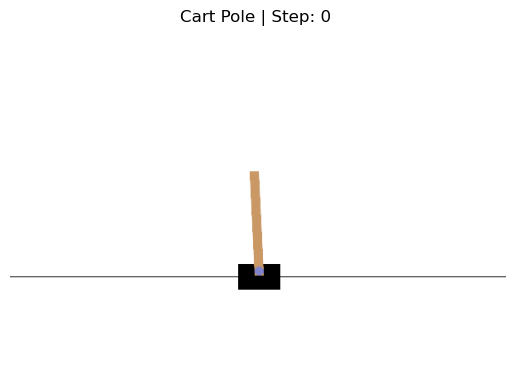

In [4]:
#
# package gymnasium comes with an API to manipulate and 
# observe the 'Cart Pole' system. 
#

env = gym.make('CartPole-v1', render_mode =  "rgb_array")
# get size of state and action from environment
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

env.reset()
obs, reward, done, info, otherstuf = env.step(0)  

# env.step(a) 
# 0: Push cart to the left
# 1: Push cart to the right

print("observation :  cart position, cart velocity, pole angle, pole angul-veloc.")
print("            :  ", obs)
print(' ')
print("plot this thing: ")

plt.figure(1)
draw_state(env)

In [5]:
class ExperimentBuffer:
    def __init__(self, maxlen=100):
        self.maxlen       = maxlen
        self.states       = deque(maxlen=self.maxlen)
        self.actions      = deque(maxlen=self.maxlen)
        self.rewards      = deque(maxlen=self.maxlen)        
        self.next_states  = deque(maxlen=self.maxlen)
        self.dones        = deque(maxlen=self.maxlen)

    def sampleBatch(self, batch_size):
        indicies = random.sample( range(len(self.states)), batch_size )
        #print(indicies)
        states      = np.array( [ self.states[index]      for index in indicies ] )
        actions     = np.array( [ self.actions[index]     for index in indicies ] )
        rewards     = np.array( [ self.rewards[index]     for index in indicies ] )
        next_states = np.array( [ self.next_states[index] for index in indicies ] )
        dones       = np.array( [ self.dones[index]       for index in indicies ] )
        #batch = [ self.replay_buffer[index] for index in indicies ]
        #states, actions, rewards, next_states, dones = [
        #    np.array( [ experience[field_index] for experience in batch ] ) 
        #    for field_index in range(5) ]
        return states, actions, rewards, next_states, dones
        

    def append( self, state, action, reward, next_state, done ):
        self.states.append(      state )
        self.actions.append(     action )
        self.rewards.append(     reward )
        self.next_states.append( next_state )
        self.dones.append(       done )

class CartPoleAgent:
    def __init__(self, env):
        self.state_size = env.observation_space.shape[0]
        self.action_size = env.action_space.n
        
        # Hyperparameters
        self.discount_factor = 0.95
        self.epsilon0        = 0.90
        self.epsilon         = self.epsilon0
        self.epsilon_cut     = 500
        self.learning_rate   = 0.005

        # data collection schema
        self.n_steps_per_ep   = 200
        self.n_eps_per_update = 10
        self.print_every_n    = 20
        self.batch_size       = 32

        # some data structures
        self.buffer_size   = 2000
        self.replay_buffer = ExperimentBuffer(maxlen=self.buffer_size)

        # Game information
        # self.state
    
        # self.model (handled by keras)
        # self.loss_fn
        # self.optimizer


    #--------------------------------------------------------------------
    # Methods for model treatment
    #
    def initOptimizers(self):
        #self.model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=self.learning_rate) )
        # self.loss_fn = keras.losses.categorical_crossentropy
        self.loss_fn   = keras.losses.mean_squared_error
        self.optimizer = keras.optimizers.Adam(learning_rate = self.learning_rate)
        
    def loadModel(self, fname):
        self.model = keras.models.load_model(fname)
        self.initOptimizers()
        #
    
    def newModel(self):
        self.model = Sequential()
        self.model.add( Input( shape=(self.state_size,) ) )
        self.model.add( Dense( 32, activation='relu' ) )
        self.model.add( Dense( 32, activation='relu' ) )
        self.model.add( Dense( 2 ) )

        self.initOptimizers()

    def saveModel(self, fname):
        self.model.save(fname)

    #--------------------------------------------------------------------
    # Model obtains Q-values
    #
    def Q(self,state):
        state = tf.cast( state.reshape([1,self.state_size]), dtype = tf.float32 , name = None)
        return self.model.predict(state, batch_size=1, verbose=0).flatten()
    
    #--------------------------------------------------------------------
    # Model predicts the next action
    #
    def getQuickEpsilonAction(self,Q_vals):
        # same as getEpsilonAction(), but
        # can be used if the Q vals were already computed
        # in the caller's subroutine.
        # Pick according to epsilon greedy
        if (np.random.rand() < self.epsilon):
            return np.random.randint(self.action_size)
        else:
            return np.argmax(Q_vals)
        
    def getEpsilonAction(self, state):
        # provided the current state as input,
        # using the output of Q network, or pick action stochastically
        if (np.random.rand() < self.epsilon):
            return np.random.randint(self.action_size)
        else:
            Q_vals = self.Q(state)
            return np.argmax(Q_vals)

    def getGreedyAction( self, state ):
        # pick the apparent 'best' action
        Q_vals = self.Q(state)
        return np.argmax(Q_vals)



    #--------------------------------------------------------------------
    # Methods for playing and sampling
    #
    def playOneStep( self, state, env ):
        #print(state)
        action = self.getEpsilonAction(state)
        next_state, reward, done, info, otherstf = env.step(action)
        self.replay_buffer.append(  state, action, reward, next_state, done )
        return next_state, reward, done 

    #def sampleExperiments( self ):
    #    indicies = random.sample( range(len(self.replay_buffer)), self.batch_size )
    #    batch = [ self.replay_buffer[index] for index in indicies ]
    #    states, actions, rewards, next_states, dones = [
    #        np.array( [ experience[field_index] for experience in batch ] ) 
    #        for field_index in range(5) ]
    #    return states, actions, rewards, next_states, dones

        
    #--------------------------------------------------------------------
    # Methods for training 
    #
    
    def trainingStep(self):
        states, actions, rewards, next_states, dones = self.replay_buffer.sampleBatch(self.batch_size)
        next_Q_vals = self.model.predict(next_states, verbose = 0)
        max_next_Q  = np.max(next_Q_vals, axis=1)
        target_Q_vals = ( rewards + (1-dones)*self.discount_factor*max_next_Q )
        target_Q_vals = target_Q_vals.reshape(-1,1)
        mask          = tf.one_hot(actions, self.action_size)
        with tf.GradientTape() as tape:
            Q_vals = self.model(states)
            Q_vals = tf.reduce_sum( Q_vals * mask, axis=1, keepdims=True )
            loss = tf.reduce_mean( self.loss_fn(target_Q_vals, Q_vals) )
        grads = tape.gradient( loss, self.model.trainable_variables )
        self.optimizer.apply_gradients(  zip(grads, self.model.trainable_variables) )
              
    def train(self, env, nepisodes):
        for episode in range(nepisodes):
            obs = env.reset()[0]
            epRewards = 0.0
            #print(obs)
            self.epsilon = max( self.epsilon - self.epsilon0/self.epsilon_cut, 0.01 ) 
            for step in range(200):                
                obs, reward, done = self.playOneStep( obs, env )
                epRewards += reward
                if done:
                    break
            if ( 0 == episode%self.print_every_n ):
                print("Training progress:  ", episode, '/', nepisodes, ".  sum rewards this ep: ", epRewards, ".  current epsilon: ", self.epsilon )
            if episode > 50:
                self.trainingStep()
            
            

In [17]:
# 
# Declare an instance of CartPoleAgent
# Lets examine the properties of the policy network
#
bath = ExperimentBuffer(maxlen = 2000)
bath.append( 2,3,4,5,6)
print(bath.sampleBatch( 1 ))

agent = CartPoleAgent(env)
agent.newModel()
agent.model.summary()

(array([2]), array([3]), array([4]), array([5]), array([6]))


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#
# Lets examine the model
# and test if each functionality is working as intended
#

state = env.reset()[0]
#state = np.reshape(state, [1, state_size])

#
# Test some of these methods
#
print("initial state:      ", state )
next_state, reward, done  = agent.playOneStep(state,env)
print("play, next state:   ", next_state )
Q_vals = agent.Q(state)
Q_vals = agent.Q(next_state)
print("Q:                  ", Q_vals )
print("quick action, eps:  ", agent.getQuickEpsilonAction(Q_vals) )
print("action, eps:        ", agent.getEpsilonAction(state) )
print("greedy action, eps: ", agent.getGreedyAction( state ) )
print("can model train?:   ")
agent.train( env, 3 )

print("whats the first element(s) of the replay buffer?: ")
print("states: ", agent.replay_buffer.states[0] )
print("actions: ", agent.replay_buffer.actions[0] )
print("rewards: ", agent.replay_buffer.rewards[0] )
print("next_states: ", agent.replay_buffer.next_states[0] )
print("dones: ", agent.replay_buffer.dones[0] )

initial state:       [-0.01561629 -0.0165506   0.02426827  0.01017449]
play, next state:    [-0.01594731  0.17821506  0.02447176 -0.2747538 ]
Q:                   [-0.00928638 -0.00786056]
quick action, eps:   0
action, eps:         1
greedy action, eps:  1
can model train?:   
Training progress:   0 / 3 .  sum rewards this ep:  17.0 .  current epsilon:  0.8982
whats the first element(s) of the replay buffer?: 
states:  [-0.01561629 -0.0165506   0.02426827  0.01017449]
actions:  1
rewards:  1.0
next_states:  [-0.01594731  0.17821506  0.02447176 -0.2747538 ]
dones:  False


In [8]:
agent.replay_buffer.states[1]
      

array([-0.01295774,  0.01990235,  0.04050907,  0.00355337], dtype=float32)

In [9]:
#
# This block sets up the model
# edit to chose between loading an old model
# or starting a new model and going through the training process
#

train_new_model = False
continue_training = False
model_name = "trainedModel_DQN.keras"

if continue_training:
    print("continuing from a partially trained model.")
    agent.loadModel(model_name)
    agent.epsilon0    = 0.01
    agent.epsilon_cut = 1
    agent.epsilon     = 0.01
    n_episodes = 500
    agent.print_every_n = 10
    agent.train(env, n_episodes)
    agent.saveModel(model_name)
elif train_new_model:
    print("training new model.")
    model_name = "trainedModel_DQN.keras" #"newNewModel.keras"
    agent.newModel()
    agent.epsilon0    = 0.90
    agent.epsilon_cut = 500
    agent.epsilon     = agent.epsilon0
    n_episodes = 800
    agent.print_every_n = 20
    agent.train(env, n_episodes)
    agent.saveModel(model_name)
else:
    print("loading past model, no training.")
    agent.loadModel(model_name)



loading past model, no training.


In [10]:
#
# Play the game now with greedy actions
# run and displ
#

obs    = env.reset()[0]
#state  = np.reshape(obs[0], [1, agent.state_size])
images = []
N      = 200

for n in range(N):
    img = env.render()
    images.append( img )    
    action = agent.getGreedyAction(state)
    next_state, reward, done, info, otherstf = env.step(action)
    state = np.reshape( next_state, [1, agent.state_size])
    
    if done:
        img = env.render()
        images.append( img )    
        N=n+1
        break


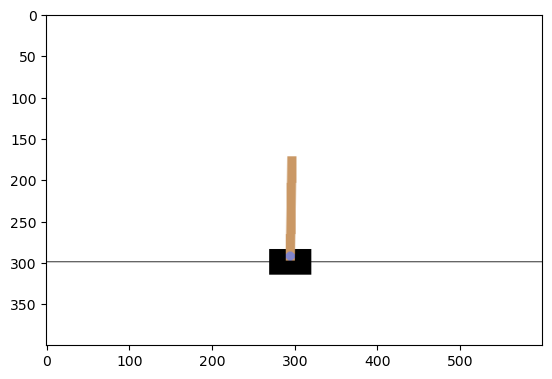

In [11]:
#
# Show animation of the result
#
from matplotlib import pyplot as plt
from IPython.display import HTML
import matplotlib.animation

fig, ax = plt.subplots()

def animate(i):
    ax.imshow(images[i])

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(images))

HTML(ani.to_jshtml())



In [14]:
# ani.save('animation_cartPole.gif', writer=matplotlib.animation.PillowWriter(fps=15))